In [2]:
import requests
from bs4 import BeautifulSoup
import re
import os
from pathlib import Path
import pandas as pd
import glob
from statistics import NormalDist
import geopandas as gpd
import zipfile
import pyarrow.parquet as pq
import sqlite3
from datetime import datetime, timedelta
from urllib.parse import urljoin
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

def file_detect(file: str, folder_path: str) -> bool:
    """
    Detect if a file exists within a given folder.

    Args:
        file (str): The file name or relative path.
        folder_path (str): The folder path to check against.

    Returns:
        bool: True if the file exists within the folder, False otherwise.
    """
    if os.path.abspath(file) != file:
        file = os.path.join(folder_path, file)
    folder_path = os.path.abspath(folder_path)
    return os.path.commonpath([file, folder_path]) == folder_path and os.path.isfile(file)


def sample_calc(population: int, confi_inter: float, p: float, error: float) -> int:
    """
    Calculate the sample size required for a given confidence interval and error margin.

    Args:
        population (int): The total population size.
        confi_inter (float): The confidence interval (e.g., 0.95 for 95% confidence).
        p (float): The estimated proportion of the population.
        error (float): The acceptable margin of error.

    Returns:
        int: The calculated sample size.
    """
    n = population
    z = NormalDist().inv_cdf((1 + confi_inter) / 2.)
    q = 1 - p
    e = error
    n_0 = (z ** 2 * p * q) / (e ** 2)
    n_final = n_0 / (1 + (n_0 - 1) / n)
    return int(n_final)


def parquet_check(file_path: str) -> bool:
    """
    Check if a given file is a valid Parquet file.

    Args:
        file_path (str): The path to the Parquet file.

    Returns:
        bool: True if the file is a valid Parquet file, False otherwise.
    """
    try:
        pq.read_table(file_path)
        return True
    except Exception:
        return False


def get_taxi_html(url: str) -> str:
    """
    Fetch HTML content from a given URL.

    Args:
        url (str): The URL to fetch content from.

    Returns:
        str: The HTML content if successful, or an empty string if an error occurs.
    """
    try:
        response = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
        })
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        print(f"Error fetching the URL: {e}")
        return ""


def download_file(url: str, download_dir: str) -> str:
    """
    Download a file from a given URL to a specified directory.

    Args:
        url (str): The URL to download the file from.
        download_dir (str): The path where the downloaded file will be saved.

    Returns:
        str: The path to the downloaded file if successful, or an empty string if an error occurs.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
        "Referer": url
    }
    try:
        response = requests.get(url, headers=headers, stream=True, timeout=60)
        response.raise_for_status()

        with open(download_dir, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                f.write(chunk)

        time.sleep(random.uniform(1, 3))
        return download_dir
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return ""

# UNIT TEST for Extra Credit

In [5]:
# Test for file_detect
def test_file_detect():
    folder_path = "/tmp/test_folder/"
    os.makedirs(folder_path, exist_ok=True)
    test_file = os.path.join(folder_path, "test.txt")
    with open(test_file, "w") as f:
        f.write("test content")
    
    # If the file exists
    assert file_detect("test.txt", folder_path) is True
    
    # If the file does not exit
    assert file_detect("non_existent.txt", folder_path) is False
    
    # Clean
    os.remove(test_file)
    os.rmdir(folder_path)

# Test for sample_calc
def test_sample_calc():
    result = sample_calc(population=10000, confi_inter=0.95, p=0.5, error=0.05)
    assert isinstance(result, int)
    assert result > 0

# Test for parquet_check
def test_parquet_check():
    folder_path = "/tmp/test_folder/"
    os.makedirs(folder_path, exist_ok=True)
    test_file = os.path.join(folder_path, "test.parquet")

    # Create an empty parquet for testing
    with open(test_file, "wb") as f:
        f.write(b"")

    # Empty file should be FALSE condition
    assert parquet_check(test_file) is False  

    os.remove(test_file)
    os.rmdir(folder_path)

# Test for get_taxi_html
def test_get_taxi_html():
    url = "https://www.example.com"
    result = get_taxi_html(url)
    assert isinstance(result, str)
    assert "<title>Example Domain</title>" in result

# Test for download_file
def test_download_file_failure():
    # a random url
    url = "https://www.randomwebsite.com/test_failure.html"
    download_dir = "/tmp/test_failure.html"
    
    file_path = download_file(url, download_dir)
    
    assert file_path == "", "Function should return an empty string on failure"
    assert not os.path.isfile(download_dir), "No file should be created on failure"

In [6]:
# Run the testing
test_file_detect()
test_sample_calc()
test_parquet_check()
test_get_taxi_html()
test_download_file_failure()

Error downloading https://www.randomwebsite.com/test_failure.html: HTTPSConnectionPool(host='www.randomwebsite.com', port=443): Max retries exceeded with url: /test_failure.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x13ea492b0>: Failed to resolve 'www.randomwebsite.com' ([Errno 8] nodename nor servname provided, or not known)"))


# Part I: DATA PROCESSING

In [8]:
# Define the url and paths
url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
directory_path = os.getcwd()
directory_path = directory_path + '/'
directory = 'data/'

In [9]:
# Define the path for data
data_path = os.path.join(directory_path, directory)

# Check if the directory exist and create it if not exist
os.makedirs(data_path, exist_ok=True)
data_path

'/Users/olaf/Columbia_Source/IEOR_4501/final_project/data/'

In [10]:
# Get the html for downloading
html = get_taxi_html(url)
if not html:
    raise 'function: get_taxi_html has encountered error'

# Catch the pattern of yellowcab 
yellow_pattern = r'<a[^>]*href=["\'](.*?)["\'][^>]*title=["\']Yellow Taxi Trip Records["\']'
yellow_matches = re.findall(yellow_pattern, html)
yellow_links = [urljoin(url, match.strip()) for match in yellow_matches]
yellow_links = [
    link for link in yellow_links
    
    if re.search(r'yellow_tripdata_(202[0-3]-(0[1-9]|1[0-2])|2024-(0[1-9]|10)).parquet', link)
]

# Catch the patten for fhvhv 
fhvhv_pattern = r'<a[^>]*href=["\'](.*?)["\'][^>]*title=["\']High Volume For-Hire Vehicle Trip Records["\']'
fhvhv_matches = re.findall(fhvhv_pattern, html)
fhvhv_links = [urljoin(url, match.strip()) for match in fhvhv_matches]
fhvhv_links = [
    link for link in fhvhv_links
    
    if re.search(r'fhvhv_tripdata_(202[0-3]-(0[1-9]|1[0-2])|2024-(0[1-9]|10)).parquet', link)
]

In [11]:
# Combine the links 
total_links = yellow_links + fhvhv_links

# For each link, check if the file exists or download the file 
for i, link in enumerate(total_links, 1):
    file_name = link.split("trip-data/")[-1]
    file_path = os.path.join(data_path, file_name)
    
    if file_detect(file_name, data_path) == False:
        print(f"({i}/{len(total_links)}) Downloading: {link}")
        downloaded_file = download_file(link, file_path)
        print(f"Downloaded: {file_name}")
    else:
        print(f"{file_name} has been downloaded！")
    
    # If the file is not parquet, delete it and re-download
    while parquet_check(file_path) == False:
        os.remove(file_path)
        print(f'{file_path} is not a parquet file, deleting and redownloading...')
        downloaded_file = download_file(link, file_path)

yellow_tripdata_2024-01.parquet has been downloaded！
yellow_tripdata_2024-02.parquet has been downloaded！
yellow_tripdata_2024-03.parquet has been downloaded！
yellow_tripdata_2024-04.parquet has been downloaded！
yellow_tripdata_2024-05.parquet has been downloaded！
yellow_tripdata_2024-06.parquet has been downloaded！
yellow_tripdata_2024-07.parquet has been downloaded！
yellow_tripdata_2024-08.parquet has been downloaded！
yellow_tripdata_2024-09.parquet has been downloaded！
yellow_tripdata_2023-01.parquet has been downloaded！
yellow_tripdata_2023-02.parquet has been downloaded！
yellow_tripdata_2023-03.parquet has been downloaded！
yellow_tripdata_2023-04.parquet has been downloaded！
yellow_tripdata_2023-05.parquet has been downloaded！
yellow_tripdata_2023-06.parquet has been downloaded！
yellow_tripdata_2023-07.parquet has been downloaded！
yellow_tripdata_2023-08.parquet has been downloaded！
yellow_tripdata_2023-09.parquet has been downloaded！
yellow_tripdata_2023-10.parquet has been downl

In [12]:
# Choose a file to check the contain and dataframe
df = pd.read_parquet(rf'{data_path}yellow_tripdata_2023-07.parquet', engine='pyarrow')
yellow_sample = pd.DataFrame(columns=df.columns)
print(df.head())


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-07-01 00:29:59   2023-07-01 00:40:15              1.0   
1         2  2023-07-01 00:03:25   2023-07-01 00:23:44              1.0   
2         2  2023-07-01 00:38:29   2023-07-01 00:48:53              1.0   
3         2  2023-07-01 00:14:16   2023-07-01 00:29:13              1.0   
4         1  2023-07-01 00:11:15   2023-07-01 00:20:47              0.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.80         1.0                  N           140           263   
1           2.31         1.0                  N           163           163   
2           2.36         1.0                  N           142           262   
3           4.36         1.0                  N            68            24   
4           1.60         1.0                  N           161           107   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [13]:
# Choose a file to check the contain and dataframe
df = pd.read_parquet(rf'{data_path}fhvhv_tripdata_2023-07.parquet', engine='pyarrow')
uber_sample = pd.DataFrame(columns=df.columns)
print(df.head())

  hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B03404               B03404   
1            HV0003               B03404               B03404   
2            HV0003               B03404               B03404   
3            HV0003               B03404               B03404   
4            HV0005               B03406                 None   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2023-07-01 00:04:21 2023-07-01 00:07:59 2023-07-01 00:08:30   
1 2023-07-01 00:40:25 2023-07-01 00:40:35 2023-07-01 00:42:10   
2 2023-07-01 00:20:31 2023-07-01 00:24:05 2023-07-01 00:25:00   
3 2023-07-01 00:42:50 2023-07-01 00:47:37 2023-07-01 00:48:57   
4 2023-07-01 00:00:17                 NaT 2023-07-01 00:05:35   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  sales_tax  \
0 2023-07-01 00:33:33            72            26       4.790  ...       1.98   
1 2023-07-01 01:08:06            26            37       

In [14]:
# Set the pattern of yellowcab and fhvhv files
yellow_paths = glob.glob(rf'{data_path}yellow_tripdata_202[0-4]-*')
fhvhv_paths = glob.glob(rf'{data_path}fhvhv_tripdata_202[0-4]-*')

# Set the uber identifiers
uber_identifiers = ['HV0003']

In [15]:
# Set the orginal population of yellowcab and uber to 0 
yellow_pop = 0
uber_pop = 0

# Detect if the sample csv is existed, if not, starting counting the sample size
if file_detect('yellow_sample.csv', directory_path) == False: 
    for file in yellow_paths:
        df = pd.read_parquet(file, engine='pyarrow')
        yellow_pop += df[df.columns[0]].count()
    yellow_sample_size = sample_calc(yellow_pop, 0.95, 0.5, 0.05)
    print(f'sample size of yellowcab is {yellow_pop}')

# Detect if the sample csv is existed, if not, starting counting the sample size
if file_detect('uber_sample.csv', directory_path) == False:         
    for file in fhvhv_paths:
        df = pd.read_parquet(file, engine='pyarrow')
        df = df[df['hvfhs_license_num'].isin(uber_identifiers)]
        uber_pop += df[df.columns[0]].count()
    uber_sample_size = sample_calc(uber_pop, 0.95, 0.5, 0.05)
    print(f'sample size of uber is {uber_pop}')

sample size of yellowcab is 163540933
sample size of uber is 683210438


In [16]:
# Make the samples be empty list and append values
samples = []

# If the sample csv is not existed, append the random rows from each file to samples
if file_detect('yellow_sample.csv', directory_path) == False:      
    
    for file in yellow_paths:
        df = pd.read_parquet(file, engine='pyarrow')
        sample_data = df.sample(n=yellow_sample_size, random_state=42)
        samples.append(sample_data)
    yellow_sample = pd.concat(samples, ignore_index=True)
    
    try:
        yellow_sample = yellow_sample[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'tip_amount', 'tolls_amount', 'PULocationID', 'DOLocationID']]
    except KeyError as e:
        print('The column names have been changed')
    # Create the csv file to store the values for future usage
    yellow_sample.to_csv(f'{directory_path}yellow_sample.csv', index=False)
    
else:
    # If the file is existed, read it 
    print('yellow_sample.csv has been created. Loading..')
    yellow_sample = pd.read_csv(f'{directory_path}yellow_sample.csv')

/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/216095763.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yellow_sample = pd.concat(samples, ignore_index=True)


In [17]:
print(yellow_sample.head())

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2023-06-28 08:27:09   2023-06-28 09:21:52              1.0          10.22   
1  2023-06-13 22:05:38   2023-06-13 22:10:48              1.0           0.80   
2  2023-06-09 10:25:49   2023-06-09 10:41:51              2.0           1.62   
3  2023-06-28 15:56:14   2023-06-28 17:22:03              1.0          18.90   
4  2023-06-22 07:12:42   2023-06-22 07:23:47              1.0           1.52   

   fare_amount  mta_tax  improvement_surcharge  congestion_surcharge  \
0         57.6      0.5                    1.0                   2.5   
1          7.2      0.5                    1.0                   2.5   
2         15.6      0.5                    1.0                   2.5   
3        114.7      0.0                    1.0                   0.0   
4         11.4      0.5                    1.0                   0.0   

   tip_amount  tolls_amount  PULocationID  DOLocationID  
0       17.09          0.00 

In [18]:
# Make the samples be empty list and append values
samples = []

# If the sample csv is not existed, append the random rows from each file to samples
if file_detect('uber_sample.csv', directory_path) == False:      
    
    for file in fhvhv_paths:
        df = pd.read_parquet(file, engine='pyarrow')
        df = df[df['hvfhs_license_num'].isin(uber_identifiers)]
        sample_data = df.sample(n=uber_sample_size, random_state=42)
        samples.append(sample_data)
    uber_sample = pd.concat(samples, ignore_index=True)    
    
    try: 
        uber_sample = uber_sample[['hvfhs_license_num', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'base_passenger_fare', 'sales_tax', 'congestion_surcharge', 'tips', 'tolls' ]]
    except KeyError as e:
        print('The column names have been changed')
    # Create the csv file to store the values for future usage
    uber_sample.to_csv(f'{directory_path}uber_sample.csv', index=False)
    
else:
    # If the file is existed, read it 
    print('uber_sample.csv has been created. Loading..')
    uber_sample = pd.read_csv(f'{directory_path}uber_sample.csv')

/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/2200108461.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  uber_sample = pd.concat(samples, ignore_index=True)


In [19]:
print(uber_sample.head())

  hvfhs_license_num     pickup_datetime    dropoff_datetime  PULocationID  \
0            HV0003 2021-03-19 08:11:50 2021-03-19 08:20:59            97   
1            HV0003 2021-03-01 22:08:28 2021-03-01 22:20:19           247   
2            HV0003 2021-03-13 05:48:40 2021-03-13 05:55:36            18   
3            HV0003 2021-03-12 21:02:02 2021-03-12 21:25:13           211   
4            HV0003 2021-03-31 08:49:53 2021-03-31 09:56:02            74   

   DOLocationID  trip_miles  trip_time  base_passenger_fare  sales_tax  \
0           231        2.52        549                12.58       1.14   
1            20        2.41        711                11.94       1.06   
2           247        2.21        416                15.25       1.35   
3           229        3.85       1391                21.51       1.91   
4            45       18.96       3969                71.31       6.89   

   congestion_surcharge  tips  tolls  
0                  2.75   0.0   0.00  
1             

In [20]:
# Define the values for zone zipfile
link = 'https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip'
zone_zipfile = 'taxi_zones.zip'
zone_zipfile_abs = directory_path + zone_zipfile
zone_file = 'taxi_zones.shp'

# If the file not existed, downloaded it 
if file_detect(zone_zipfile, directory_path) == False:      
    response = requests.get(link)
    with open(zone_zipfile_abs, 'wb') as file:
        file.write(response.content)

# Unzip the file if not unziped
if file_detect(zone_file, directory_path) == False:
    with zipfile.ZipFile(zone_zipfile_abs, 'r') as zip_ref:
        zip_ref.extractall(directory_path)

# loading the taxi_zones
zone_gdf = gpd.read_file(f"{directory_path}taxi_zones.shp")



In [21]:
# Find the latitude and longitude by geometry.centroid
try:    
    
    zone_gdf['centroid'] = zone_gdf.geometry.centroid
    zone_gdf['centroid'] = zone_gdf['centroid'].to_crs(epsg=4326)
    zone_gdf['latitude'] = zone_gdf['centroid'].y
    zone_gdf['longitude'] = zone_gdf['centroid'].x   
    zone_gdf = zone_gdf[['LocationID', 'latitude', 'longitude']]
except AttributeError as e:
    print('The DataFrame has been edited')

In [22]:
# Fix the issue of duplicate ids and assign them to the ids with no coors
zone_gdf.loc[56, 'LocationID'] = 57.0
zone_gdf.loc[103, 'LocationID'] = 104.0
zone_gdf.loc[104, 'LocationID'] = 105.0
zone_gdf.loc[105, 'LocationID'] = 106.0

In [23]:
# Latitude and Longitude Range
lat_min, lon_min = 40.560445, -74.242330
lat_max, lon_max = 40.908524, -73.717047
    
# Match the latitude and longitude of the dataset
if 'LocationID_pickup' not in yellow_sample:
    yellow_sample = yellow_sample.merge(zone_gdf, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))
    yellow_sample = yellow_sample.merge(zone_gdf, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))
if 'LocationID_dropoff' not in yellow_sample:
    yellow_sample = yellow_sample.merge(zone_gdf, how='left', left_on='DOLocationID', right_on='LocationID', suffixes=('', '_dropoff'))
 
# Keep the rows that has different pickup location and drop location, and both pick up and drop off location id are in the zone dataframe
yellow_sample = yellow_sample[(yellow_sample['PULocationID'] != yellow_sample['DOLocationID'])
& (yellow_sample['trip_distance'] > 0) 
& (yellow_sample['PULocationID'] <= 263) 
& (yellow_sample['DOLocationID'] <= 263) 
]

# Drop the duplicated columns
yellow_sample = yellow_sample.loc[:,~yellow_sample.columns.duplicated()]

# Change the dtype of both pick up and drop off location id to int64
yellow_sample['LocationID_pickup'] = yellow_sample['LocationID_pickup'].astype('int64')
yellow_sample['LocationID_dropoff'] = yellow_sample['LocationID_dropoff'].astype('int64')

# Sanity Check: All the PULocationID should match pick up location id, and DOLocationID should match drop off location id
if yellow_sample['PULocationID'].all() != yellow_sample['LocationID_pickup'].all() & yellow_sample['DOLocationID'].all() != yellow_sample['LocationID_dropoff'].all():
    raise('Pickup Location or Dropoff Location ID not matached. Something went wrong!')

# Rename the columns
yellow_sample.rename(columns={
    'tpep_pickup_datetime': 'PUDatetime',
    'tpep_dropoff_datetime': 'DODatetime'
}, inplace=True)

# Set the appropriate dtype for each column
yellow_sample['PUDatetime'] = pd.to_datetime(yellow_sample['PUDatetime'])
yellow_sample['DODatetime'] = pd.to_datetime(yellow_sample['DODatetime'])
yellow_sample['trip_distance'] = yellow_sample['trip_distance'].astype(float)

# Keep the data only within the range 
yellow_sample = yellow_sample[
    (yellow_sample['latitude_pickup'].between(lat_min, lat_max)) & 
    (yellow_sample['longitude_pickup'].between(lon_min, lon_max)) &
    (yellow_sample['latitude_dropoff'].between(lat_min, lat_max)) &
    (yellow_sample['longitude_dropoff'].between(lon_min, lon_max))
]

# Drop the columns useless columns
yellow_sample = yellow_sample.drop(['PULocationID', 'DOLocationID', 'LocationID', 'latitude', 'longitude'], axis=1)

yellow_sample


,PUDatetime,DODatetime,passenger_count,trip_distance,fare_amount,mta_tax,improvement_surcharge,congestion_surcharge,tip_amount,tolls_amount,LocationID_pickup,latitude_pickup,longitude_pickup,LocationID_dropoff,latitude_dropoff,longitude_dropoff
0,2023-06-28 08:27:09,2023-06-28 09:21:52,1.0,10.22,57.6,0.5,1.0,2.5,17.09,0.00,138,40.774376,-73.873628,144,40.720889,-73.996919
1,2023-06-13 22:05:38,2023-06-13 22:10:48,1.0,0.80,7.2,0.5,1.0,2.5,0.00,0.00,263,40.778766,-73.951010,237,40.768615,-73.965635
2,2023-06-09 10:25:49,2023-06-09 10:41:51,2.0,1.62,15.6,0.5,1.0,2.5,2.00,0.00,162,40.756688,-73.972356,236,40.780436,-73.957012
3,2023-06-28 15:56:14,2023-06-28 17:22:03,1.0,18.90,114.7,0.0,1.0,0.0,27.65,22.75,229,40.756729,-73.965146,1,40.691830,-74.174002
4,2023-06-22 07:12:42,2023-06-22 07:23:47,1.0,1.52,11.4,0.5,1.0,0.0,1.94,0.00,43,40.782477,-73.965555,74,40.801169,-73.937346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21882,2023-03-31 17:46:57,2023-03-31 17:56:36,1.0,1.29,10.0,0.5,1.0,2.5,0.82,0.00,164,40.748575,-73.985156,68,40.748427,-73.999918
21883,2023-03-02 11:43:52,2023-03-02 11:54:43,0.0,1.40,10.0,0.5,1.0,2.5,1.50,0.00,90,40.742279,-73.996971,114,40.728340,-73.997380
21884,2023-03-12 22:04:08,2023-03-12 22:13:13,5.0,0.97,7.9,0.5,1.0,2.5,3.87,0.00,90,40.742279,-73.996971,234,40.740337,-73.990458
21885,2023-03-06 20:59:31,2023-03-06 21:05:50,2.0,0.90,7.9,0.5,1.0,2.5,2.55,0.00,163,40.764421,-73.977569,162,40.756688,-73.972356


In [24]:
# Latitude and Longitude Range
lat_min, lon_min = 40.560445, -74.242330
lat_max, lon_max = 40.908524, -73.717047
    
# Match the latitude and longitude of the dataset
if 'LocationID_pickup' not in uber_sample:
    # This command need to be run twice because the first time suffixes do not work
    uber_sample = uber_sample.merge(zone_gdf, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))
    uber_sample = uber_sample.merge(zone_gdf, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))
    

if 'LocationID_dropoff' not in uber_sample:
    uber_sample = uber_sample.merge(zone_gdf, how='left', left_on='DOLocationID', right_on='LocationID', suffixes=('', '_dropoff'))

# Keep the rows that has different pickup location and drop location, and both pick up and drop off location id are in the zone dataframe
uber_sample = uber_sample[(uber_sample['PULocationID'] != uber_sample['DOLocationID']) & 
(uber_sample['trip_miles'] > 0) & 
(uber_sample['PULocationID'] <= 263) & 
(uber_sample['DOLocationID'] <= 263) 
 
]

# Drop the duplicated columns
uber_sample = uber_sample.loc[:,~uber_sample.columns.duplicated()]

# Change the dtype of both pick up and drop off location id to int64
uber_sample['LocationID_pickup'] = uber_sample['LocationID_pickup'].astype('int64')
uber_sample['LocationID_dropoff'] = uber_sample['LocationID_dropoff'].astype('int64')

# Sanity Check: All the PULocationID should match pick up location id, and DOLocationID should match drop off location id
if uber_sample['PULocationID'].all() != uber_sample['LocationID_pickup'].all() & uber_sample['DOLocationID'].all() != uber_sample['LocationID_dropoff'].all():
    raise('Pickup Location or Dropoff Location ID not matached. Something went wrong!')

# Rename the columns
uber_sample.rename(columns={
    'pickup_datetime': 'PUDatetime',
    'dropoff_datetime': 'DODatetime',
    'trip_miles': 'trip_distance'
}, inplace=True)

# Set the appropriate dtype for each column
uber_sample['PUDatetime'] = pd.to_datetime(uber_sample['PUDatetime'])
uber_sample['DODatetime'] = pd.to_datetime(uber_sample['DODatetime'])
uber_sample['trip_distance'] = uber_sample['trip_distance'].astype(float)

# Keep the data only within the range 
uber_sample = uber_sample[
    (uber_sample['latitude_pickup'].between(lat_min, lat_max)) & 
    (uber_sample['longitude_pickup'].between(lon_min, lon_max)) &
    (uber_sample['latitude_dropoff'].between(lat_min, lat_max)) &
    (uber_sample['longitude_dropoff'].between(lon_min, lon_max))
]

# Drop the columns useless columns
uber_sample = uber_sample.drop(['PULocationID', 'DOLocationID', 'LocationID', 'latitude', 'longitude'], axis=1)

uber_sample

,hvfhs_license_num,PUDatetime,DODatetime,trip_distance,trip_time,base_passenger_fare,sales_tax,congestion_surcharge,tips,tolls,LocationID_pickup,latitude_pickup,longitude_pickup,LocationID_dropoff,latitude_dropoff,longitude_dropoff
0,HV0003,2021-03-19 08:11:50,2021-03-19 08:20:59,2.52,549,12.58,1.14,2.75,0.0,0.00,97,40.690787,-73.974882,231,40.717773,-74.007880
1,HV0003,2021-03-01 22:08:28,2021-03-01 22:20:19,2.41,711,11.94,1.06,0.00,0.0,0.00,247,40.828987,-73.924410,20,40.857779,-73.885867
2,HV0003,2021-03-13 05:48:40,2021-03-13 05:55:36,2.21,416,15.25,1.35,0.00,0.0,0.00,18,40.867682,-73.890184,247,40.828987,-73.924410
3,HV0003,2021-03-12 21:02:02,2021-03-12 21:25:13,3.85,1391,21.51,1.91,2.75,0.0,0.00,211,40.723888,-74.001538,229,40.756729,-73.965146
4,HV0003,2021-03-31 08:49:53,2021-03-31 09:56:02,18.96,3969,71.31,6.89,2.75,0.0,6.12,74,40.801169,-73.937346,45,40.712459,-73.998151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21882,HV0003,2024-07-04 07:16:01,2024-07-04 07:25:15,1.74,554,10.05,0.94,0.00,0.0,0.00,242,40.846783,-73.850671,212,40.827902,-73.869680
21883,HV0003,2024-07-27 08:46:14,2024-07-27 08:59:37,2.35,803,13.61,1.21,2.75,0.0,0.00,151,40.797962,-73.968168,142,40.773633,-73.981532
21884,HV0003,2024-07-12 17:13:48,2024-07-12 17:23:18,2.65,570,15.19,1.43,0.00,5.0,0.00,150,40.580473,-73.943629,123,40.599954,-73.964334
21886,HV0003,2024-07-23 11:39:13,2024-07-23 11:52:06,2.06,773,9.83,0.87,0.00,0.0,0.00,42,40.818257,-73.940772,244,40.841708,-73.941399


In [25]:
# Define the weather path
weather_path = data_path + "weather_data/"

file_paths = [
    '2020_weather.csv',
    '2021_weather.csv',
    '2022_weather.csv',
    '2023_weather.csv',
    '2024_weather.csv'
]

# Combine all csv 
dfs = [pd.read_csv(weather_path + file_path) for file_path in file_paths]
weather_df = pd.concat(dfs, ignore_index=True)
weather_df.head()

/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/2310945333.py:13: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(weather_path + file_path) for file_path in file_paths]
/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/2310945333.py:13: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(weather_path + file_path) for file_path in file_paths]
/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/2310945333.py:13: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(weather_path + file_path) for file_path in file_paths]
/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/2310945333.py:13: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or se

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2020-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.66,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
1,72505394728,2020-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.67,27,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
2,72505394728,2020-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.68,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
3,72505394728,2020-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,24,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
4,72505394728,2020-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,23,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18


In [26]:
# Define weather hourly
weather_hourly = weather_df[['DATE', 'HourlyDryBulbTemperature', 'HourlyWindSpeed', 'HourlyPrecipitation']].dropna()
weather_hourly['HourlyPrecipitation'] = weather_hourly['HourlyPrecipitation'].replace('T', 0.001)
weather_hourly['DATE'] = pd.to_datetime(weather_hourly['DATE'])
weather_hourly['HourlyDryBulbTemperature'] = pd.to_numeric(weather_hourly['HourlyDryBulbTemperature'], errors='coerce')
weather_hourly.head()

,DATE,HourlyDryBulbTemperature,HourlyWindSpeed,HourlyPrecipitation
0,2020-01-01 00:51:00,40.0,8.0,0.00
1,2020-01-01 01:51:00,39.0,8.0,0.00
2,2020-01-01 02:51:00,39.0,14.0,0.00
3,2020-01-01 03:51:00,39.0,11.0,0.00
4,2020-01-01 04:51:00,38.0,6.0,0.00


In [27]:
# Define weather daily
weather_daily = weather_df[['DATE', 'DailyAverageDryBulbTemperature', 'DailyAverageWindSpeed', 'DailyPrecipitation', 'DailyWeather', 'DailySnowfall']].dropna()
weather_daily['DailyPrecipitation'] = weather_daily['DailyPrecipitation'].replace('T', 0.001)
weather_daily['DailySnowfall'] = weather_daily['DailySnowfall'].replace('T', 0.001)
weather_daily['DATE'] = pd.to_datetime(weather_daily['DATE'])
weather_daily['DailyAverageDryBulbTemperature'] = pd.to_numeric(weather_daily['DailyAverageDryBulbTemperature'], errors='coerce')
weather_daily

,DATE,DailyAverageDryBulbTemperature,DailyAverageWindSpeed,DailyPrecipitation,DailyWeather,DailySnowfall
86,2020-01-03 23:59:00,47.0,3.4,0.15,RA BR HZ,0.0
144,2020-01-04 23:59:00,46.0,4.4,0.27,RA FG BR,0.0
169,2020-01-05 23:59:00,39.0,11.3,0.001,RA,0.0
205,2020-01-06 23:59:00,39.0,6.1,0.04,SN BR,0.2
259,2020-01-08 23:59:00,35.0,9.7,0.001,SN,0.001
...,...,...,...,...,...,...
54807,2024-09-07 23:59:00,68.0,3.4,0.24,RA FG BR,0.0
54936,2024-09-12 23:59:00,71.0,1.8,0.00,BR HZ,0.0
54961,2024-09-13 23:59:00,73.0,1.4,0.00,BR HZ,0.0
55239,2024-09-23 23:59:00,63.0,5.8,0.04,RA,0.0


In [28]:
# Extra Credit DataFrame
weather_sun = weather_df[['DATE', 'Sunrise', 'Sunset']].dropna()
weather_sun['DATE'] = pd.to_datetime(weather_sun['DATE'])
weather_sun['Sunrise'] = weather_sun['Sunrise'].astype(int)
weather_sun['Sunset'] = weather_sun['Sunset'].astype(int)
weather_sun

,DATE,Sunrise,Sunset
24,2020-01-01 23:59:00,720,1639
49,2020-01-02 23:59:00,720,1640
86,2020-01-03 23:59:00,720,1641
144,2020-01-04 23:59:00,720,1642
169,2020-01-05 23:59:00,720,1643
...,...,...,...
55979,2024-10-17 23:59:00,610,1711
56004,2024-10-18 23:59:00,611,1710
56028,2024-10-19 23:59:00,612,1708
56053,2024-10-20 23:59:00,613,1707


# PART II: STORING DATA

In [30]:
# Connection to sql server
connection = sqlite3.connect("project.db")
cursor = connection.cursor()

In [31]:
# Import the schema
!sqlite3 project.db < schema.sql

In [32]:
# Check the tables of database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('yellowcab',),
 ('uber',),
 ('hourly_weather',),
 ('daily_weather',),
 ('weather_sun',)]

In [51]:
# Define the query of inserting yellowcab
yellow_insert = """
INSERT OR IGNORE INTO yellowcab (pickup_time, dropoff_time, passenger_num, trip_distance, fare_amount, tax, surcharges, tip, toll, latitude_dropoff, longitude_dropoff, latitude_pickup, longitude_pickup)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
"""

# Define the values
values = [
    (
        row['PUDatetime'].strftime('%Y-%m-%d %H:%M:%S'),
        row['DODatetime'].strftime('%Y-%m-%d %H:%M:%S'),
        row['passenger_count'],
        row['trip_distance'],
        row['fare_amount'],
        row['mta_tax'],
        row['improvement_surcharge'] + row['congestion_surcharge'],
        row['tip_amount'],
        row['tolls_amount'],
        row['latitude_dropoff'],
        row['longitude_dropoff'],
        row['latitude_pickup'],
        row['longitude_pickup']
    )
    for _, row in yellow_sample.iterrows()
]
cursor.executemany(yellow_insert, values) 
connection.commit()

In [53]:
# Define the query for inserting uber
uber_insert = """
INSERT OR IGNORE INTO uber (pickup_time, dropoff_time, trip_time, trip_distance, fare_amount, tax, surcharges, tip, toll, latitude_dropoff, longitude_dropoff, latitude_pickup, longitude_pickup)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?, ?, ?, ?);
"""

# Define the values
values = [
    (
        row['PUDatetime'].strftime('%Y-%m-%d %H:%M:%S'),
        row['DODatetime'].strftime('%Y-%m-%d %H:%M:%S'),
        row['trip_time'],
        row['trip_distance'],
        row['base_passenger_fare'],
        row['sales_tax'],
        row['congestion_surcharge'],
        row['tips'],
        row['tolls'],
        row['latitude_dropoff'],
        row['longitude_dropoff'],
        row['latitude_pickup'],
        row['longitude_pickup']
    )
    for _, row in uber_sample.iterrows()
]
cursor.executemany(uber_insert, values) 
connection.commit()

In [55]:
# Sanity Check: Does the database contain the value?
result = cursor.execute("SELECT * FROM uber;")
result = result.fetchall()
result

[(1,
  '2021-03-19 08:11:50',
  '2021-03-19 08:20:59',
  549.0,
  2.52,
  12.58,
  1.14,
  2.75,
  0.0,
  0.0,
  40.71777262479923,
  -74.0078796687525,
  40.690786583767746,
  -73.9748820144768),
 (2,
  '2021-03-01 22:08:28',
  '2021-03-01 22:20:19',
  711.0,
  2.41,
  11.94,
  1.06,
  0.0,
  0.0,
  0.0,
  40.857779440562844,
  -73.88586744911127,
  40.82898744957318,
  -73.9244099256833),
 (3,
  '2021-03-13 05:48:40',
  '2021-03-13 05:55:36',
  416.0,
  2.21,
  15.25,
  1.35,
  0.0,
  0.0,
  0.0,
  40.82898744957318,
  -73.9244099256833,
  40.86768222238494,
  -73.89018381164814),
 (4,
  '2021-03-12 21:02:02',
  '2021-03-12 21:25:13',
  1391.0,
  3.85,
  21.51,
  1.91,
  2.75,
  0.0,
  0.0,
  40.75672890813223,
  -73.96514581878095,
  40.723888072060404,
  -74.00153759512791),
 (5,
  '2021-03-31 08:49:53',
  '2021-03-31 09:56:02',
  3969.0,
  18.96,
  71.31,
  6.89,
  2.75,
  0.0,
  6.12,
  40.712459285136994,
  -73.99815145865519,
  40.80116912880846,
  -73.9373456595586),
 (6,
  '2

In [57]:
# Define the query for hourly weather
weather_hourly_insert = """
INSERT OR IGNORE INTO hourly_weather (date, temperature, wind_speed, precipitation)
VALUES (?, ?, ?, ?);
"""

# Define the values
values = [
    (
        row['DATE'].strftime('%Y-%m-%d %H:%M:%S'),
        row['HourlyDryBulbTemperature'],
        row['HourlyWindSpeed'],
        row['HourlyPrecipitation']
    )
    for _, row in weather_hourly.iterrows()
]
cursor.executemany(weather_hourly_insert, values) 
connection.commit()

In [58]:
# Define the query for daily weather
weather_daily_insert = """
INSERT OR IGNORE INTO daily_weather (date, temperature, wind_speed, precipitation, weather, snow)
VALUES (?, ?, ?, ?, ?, ?);
"""

# Define the values
values = [
    (
        row['DATE'].strftime('%Y-%m-%d %H:%M:%S'),
        row['DailyAverageDryBulbTemperature'],
        row['DailyAverageWindSpeed'],
        row['DailyPrecipitation'],
        row['DailyWeather'],
        row['DailySnowfall']
    )
    for _, row in weather_daily.iterrows()
]
cursor.executemany(weather_daily_insert, values) 
connection.commit()


In [59]:
# Define the query for sunrise and sunset
weather_sun_insert = """
INSERT OR IGNORE INTO weather_sun (date, sunrise, sunset)
VALUES (?, ?, ?);
"""

# Define the value
values = [
    (
        row['DATE'].strftime('%Y-%m-%d %H:%M:%S'),
        row['Sunrise'],
        row['Sunset']
    )
    for _, row in weather_sun.iterrows()
]
cursor.executemany(weather_sun_insert, values) 
connection.commit()

# Close the connection
connection.close()

In [60]:
# #This cell is used to remove the database. Do not use!

# db_path = 'project.db'
# if os.path.exists(db_path):
#     os.remove(db_path)

# PART III: UNDERSTANDING DATA

In [66]:
# Connect to database
connection = sqlite3.connect("project.db")
cursor = connection.cursor()

## Q1: What’s the most popular hour to take a taxi?

In [69]:
# Define the query, find the rows from 2020/01/01 to 2024/09/01
# Use COUNT to find the number of trips 
# Use GROUP BY to know the hour
q1_query = '''
SELECT 
    strftime('%H', pickup_time) AS hour, 
    COUNT(*) AS trip_count
FROM 
    yellowcab
WHERE 
    pickup_time >= '2020-01-01' 
    AND pickup_time < '2024-09-01'
GROUP BY 
    hour
ORDER BY 
    trip_count DESC;
'''
result = cursor.execute(q1_query)
result = result.fetchall()
print(f'The most popular hour to take a taxi is ordered by {result}')

The most popular hour to take a taxi is ordered by [('18', 1377), ('17', 1331), ('15', 1297), ('16', 1239), ('14', 1227), ('13', 1129), ('19', 1120), ('12', 1108), ('21', 978), ('11', 965), ('20', 962), ('10', 932), ('09', 841), ('22', 802), ('08', 753), ('23', 661), ('07', 544), ('00', 452), ('01', 322), ('06', 317), ('02', 180), ('03', 142), ('05', 116), ('04', 85)]


## Q2: What’s the most popular day of the week to take an Uber?

In [72]:
# Define the query
# Use Count again
q2_query = '''
SELECT 
    strftime('%w', pickup_time) AS day_of_week, 
    COUNT(*) AS trip_count
FROM 
    uber
WHERE 
    pickup_time >= '2020-01-01' 
    AND pickup_time < '2024-09-01'
GROUP BY 
    day_of_week
ORDER BY 
    trip_count DESC;
'''
result = cursor.execute(q2_query)
result = result.fetchall()
print(f'The most popular day of the week to take uber is {result}. 6 means Saturday, and 0 means Sunday.')

The most popular day of the week to take uber is [('6', 3274), ('5', 2952), ('0', 2695), ('4', 2694), ('3', 2620), ('2', 2450), ('1', 2449)]. 6 means Saturday, and 0 means Sunday.


## Q3: What’s the 95% percentile of trip distance in January 2024?

In [75]:
# Set the time period from 2024/01/01 to 2024/02/01 
q3_query = '''
SELECT 
    trip_distance
FROM 
    yellowcab
WHERE 
    pickup_time >= '2024-01-01' 
    AND pickup_time < '2024-02-01';
'''

# Calculate the quantile
q3_df = pd.read_sql_query(q3_query, connection)
percentile_95 = q3_df['trip_distance'].quantile(0.95)
print("95th percentile of trip distance in January 2024:", percentile_95)

95th percentile of trip distance in January 2024: 16.78


## Q4: What was the weather like for the busiest days in 2023?

In [78]:
# Find the total rides and average distance for yellowcab
q4_yellowcab = '''
SELECT 
    DATE(pickup_time) AS date,
    COUNT(*) AS total_rides_yellow,
    AVG(trip_distance) AS avg_distance_yellow
FROM 
    yellowcab
WHERE 
    pickup_time >= '2023-01-01' AND pickup_time < '2024-01-01'
GROUP BY 
    date;
'''
# Let the result be a dataframe
yellowcab_df = pd.read_sql_query(q4_yellowcab, connection)
yellowcab_df

,date,total_rides_yellow,avg_distance_yellow
0,2023-01-01,7,3.130000
1,2023-01-02,12,4.047500
2,2023-01-03,11,4.977273
3,2023-01-04,14,3.051429
4,2023-01-05,14,3.652143
...,...,...,...
357,2023-12-27,15,3.968000
358,2023-12-28,9,1.987778
359,2023-12-29,10,2.331000
360,2023-12-30,6,3.508333


In [80]:
# Fidn the total rides and average distance for uber
q4_uber = '''
SELECT 
    DATE(pickup_time) AS date,
    COUNT(*) AS total_rides_uber,
    AVG(trip_distance) AS avg_distance_uber
FROM 
    uber
WHERE 
    pickup_time >= '2023-01-01' AND pickup_time < '2024-01-01'
GROUP BY 
    date;
'''

# Let the result be a dataframe
uber_df = pd.read_sql_query(q4_uber, connection)
uber_df

,date,total_rides_uber,avg_distance_uber
0,2023-01-01,11,4.915455
1,2023-01-02,11,5.047273
2,2023-01-03,7,2.071429
3,2023-01-04,5,7.822000
4,2023-01-05,13,7.566154
...,...,...,...
360,2023-12-27,9,5.575556
361,2023-12-28,13,5.441538
362,2023-12-29,7,3.498571
363,2023-12-30,11,4.009091


In [82]:
# Merge them to a new database to find the total rides
hired_rides = pd.merge(yellowcab_df, uber_df, on='date', how='outer')
hired_rides['total_rides_uber'] = hired_rides['total_rides_uber'].dropna()
hired_rides['total_rides_yellow'] = hired_rides['total_rides_yellow'].dropna()

# Add both rides to total rides
hired_rides['total_rides'] = hired_rides['total_rides_uber'] + hired_rides['total_rides_yellow']

# Find the average
hired_rides['average_distance'] = (hired_rides['avg_distance_yellow'] + hired_rides['avg_distance_uber']) / 2 

# Clean the data
hired_rides = hired_rides[['date', 'total_rides', 'average_distance']]

In [84]:
# Limit the rows to 10 only
top_rides = hired_rides.nlargest(10, 'total_rides')
top_rides['total_rides'] = top_rides['total_rides'].astype(int)
top_rides

,date,total_rides,average_distance
193,2023-07-13,37,4.716197
335,2023-12-02,37,4.579635
39,2023-02-09,36,4.610000
269,2023-09-27,35,4.560801
286,2023-10-14,35,2.802583
13,2023-01-14,34,2.931179
342,2023-12-09,34,3.241044
195,2023-07-15,33,4.064586
209,2023-07-29,33,5.474000
74,2023-03-16,32,4.446412


In [86]:
# Define an empty list weather
weather = []

# Select the day of the weather from previous dataframe
for day in top_rides['date']:
    date_obj = datetime.strptime(day, "%Y-%m-%d")
    next_datetime = date_obj + timedelta(days=1)
    next_date = next_datetime.strftime("%Y-%m-%d")
    q4_weather_query = f'''
    SELECT 
        Date(date) as date, precipitation, wind_speed   
    FROM
        daily_weather
    WHERE date >= '{day}' AND date < '{next_date}';
    '''
    weather_result = cursor.execute(q4_weather_query)
    weather_result = weather_result.fetchall()

    # If the weather cannot be found, make it NaN
    if len(weather_result) == 0:
        weather += [(day, 'NaN', 'NaN')]
    else:
        weather += weather_result

# Define the df of weather and merge
q4_weather_df = pd.DataFrame(columns=['date', 'precipitation', 'wind_speed'], data=weather)
q4_df = pd.merge(top_rides, q4_weather_df, on='date', how='outer')

# Make it to list and print the answer
q4_list = list(q4_df.to_records(index=False))
print(f'The top 10 best days in 2023 with date, ride amounts, average distances, precipitation, and wind speed are \n {q4_list}. \nIf the result is NaN, it means that the weather does not included into the dataset')

The top 10 best days in 2023 with date, ride amounts, average distances, precipitation, and wind speed are 
 [('2023-01-14', 34, 2.93117857, 0.001, 9.0), ('2023-02-09', 36, 4.61, 'NaN', 'NaN'), ('2023-03-16', 32, 4.44641176, 'NaN', 'NaN'), ('2023-07-13', 37, 4.71619697, 'NaN', 'NaN'), ('2023-07-15', 33, 4.06458647, 0.04, 1.5), ('2023-07-29', 33, 5.474, 0.06, 5.1), ('2023-09-27', 35, 4.56080065, 'NaN', 'NaN'), ('2023-10-14', 35, 2.80258333, 0.81, 4.4), ('2023-12-02', 37, 4.5796345, 0.0, 2.2), ('2023-12-09', 34, 3.24104396, 0.001, 2.1)]. 
If the result is NaN, it means that the weather does not included into the dataset


## Q5: How many rides were hired during snow days?


In [89]:
# Find the rows that has snow amount bigger than 0.001
q5_snow_query = '''
SELECT 
    Date(date) as date, snow
FROM
    daily_weather
WHERE 
    SNOW>'0.001'
ORDER BY
    SNOW DESC
LIMIT 10;
'''

# Make it a df
snow_df = pd.read_sql_query(q5_snow_query, connection)
snow_df

,date,snow
0,2021-02-01,14.8
1,2022-01-29,7.3
2,2020-12-16,6.5
3,2022-01-07,5.8
4,2021-02-07,4.5
5,2020-12-17,4.0
6,2021-02-18,3.2
7,2024-02-13,3.2
8,2020-01-18,2.1
9,2021-01-31,2.0


In [91]:
# Define the empty lists
yellow_rides = []
uber_rides = []

# Use for loop to append the data by matching dates
for date in snow_df['date']:
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    next_datetime = date_obj + timedelta(days=1)
    next_date = next_datetime.strftime("%Y-%m-%d")
    q5_yellowcab = f'''
    SELECT 
        DATE(pickup_time) AS date,
        COUNT(*) AS total_rides_yellow
    FROM 
        yellowcab
    WHERE 
        pickup_time >='{date}' AND pickup_time < '{next_date}'
    GROUP BY 
        date;
    '''
    yellow_result = cursor.execute(q5_yellowcab)
    yellow_rides += yellow_result.fetchall()
    q5_uber = f'''
    SELECT 
        DATE(pickup_time) AS date,
        COUNT(*) AS total_rides_uber
    FROM 
        uber
    WHERE 
        pickup_time >='{date}' AND pickup_time < '{next_date}'
    GROUP BY 
        date;
    '''
    uber_result = cursor.execute(q5_uber)
    uber_rides += uber_result.fetchall()

In [93]:
# Make the dataframe for both yellowcab and uber
yellowcab_snow_df = pd.DataFrame(columns=['date', 'yellow_rides'], data=yellow_rides)
uber_snow_df = pd.DataFrame(columns=['date', 'uber_rides'], data=uber_rides)

# Merge both and have the total rides
hired_rides_snow = pd.merge(yellowcab_snow_df, uber_snow_df, on='date', how='outer')
hired_rides_snow['total_rides'] = hired_rides_snow['yellow_rides'] + hired_rides_snow['uber_rides']
hired_rides_snow = hired_rides_snow[['date' , 'total_rides']]
hired_rides_snow

,date,total_rides
0,2020-01-18,36
1,2020-12-16,23
2,2020-12-17,9
3,2021-01-31,9
4,2021-02-01,6
5,2021-02-07,16
6,2021-02-18,19
7,2022-01-07,21
8,2022-01-29,18
9,2024-02-13,20


In [95]:
# Merge the snow df and total ride
q5_df = pd.merge(snow_df, hired_rides_snow, on='date', how='outer')
q5_df = q5_df.sort_values(by=['snow'], ascending=False)
q5_list = list(q5_df.to_records(index=False))
print(f'The top 10 largest snow days with date, snow amount, and rides amounts are \n{q5_list}')

The top 10 largest snow days with date, snow amount, and rides amounts are 
[('2021-02-01', 14.8, 6), ('2022-01-29', 7.3, 18), ('2020-12-16', 6.5, 23), ('2022-01-07', 5.8, 21), ('2021-02-07', 4.5, 16), ('2020-12-17', 4., 9), ('2021-02-18', 3.2, 19), ('2024-02-13', 3.2, 20), ('2020-01-18', 2.1, 36), ('2021-01-31', 2., 9)]


## Q6: 

In [98]:
# Start date was 2023/09/25 3 days before
# End date was 2023/10/03 3 days after
# Find the total rides between
yellow_query_rides = '''
SELECT 
    strftime('%Y-%m-%d %H:00:00', pickup_time) AS date_hour,
    COUNT(*) AS yellow_rides
FROM 
    (
        SELECT pickup_time FROM yellowcab
        WHERE pickup_time >= '2023-09-25' AND pickup_time < '2023-10-04'
        UNION ALL
        SELECT pickup_time FROM uber
        WHERE pickup_time >= '2023-09-25' AND pickup_time < '2023-10-04'
    )
GROUP BY 
    date_hour
ORDER BY 
    date_hour;
'''
yellow_rides_df = pd.read_sql_query(yellow_query_rides, connection)


uber_query_rides = '''
SELECT 
    strftime('%Y-%m-%d %H:00:00', pickup_time) AS date_hour,
    COUNT(*) AS uber_rides
FROM 
    (
        SELECT pickup_time FROM uber
        WHERE pickup_time >= '2023-09-25' AND pickup_time < '2023-10-04'
        UNION ALL
        SELECT pickup_time FROM uber
        WHERE pickup_time >= '2023-09-25' AND pickup_time < '2023-10-04'
    )
GROUP BY 
    date_hour
ORDER BY 
    date_hour;
'''
uber_rides_df = pd.read_sql_query(uber_query_rides, connection)


In [100]:
# Merge both yellowcab and uber
hired_rides_q6 = pd.merge(yellow_rides_df, uber_rides_df, on='date_hour', how='outer')
hired_rides_q6['total_rides'] = hired_rides_q6['yellow_rides'] + hired_rides_q6['uber_rides']
hired_rides_q6 = hired_rides_q6[['date_hour', 'total_rides']]

In [102]:
#'Select * from hourly_weather;'
hourly_wq = '''
SELECT 
    strftime('%Y-%m-%d %H:00:00', date) AS date_hour,
    wind_speed,
    precipitation
FROM 
    hourly_weather
WHERE 
    date_hour >= '2023-09-25' AND date_hour < '2023-10-04'
GROUP BY 
    date_hour
ORDER BY 
    date_hour;
    '''
hourlyw = pd.read_sql_query(hourly_wq, connection)
hourlyw

,date_hour,wind_speed,precipitation
0,2023-09-25 00:00:00,8.0,0.01
1,2023-09-25 01:00:00,6.0,0.01
2,2023-09-25 02:00:00,7.0,0.07
3,2023-09-25 03:00:00,7.0,0.02
4,2023-09-25 04:00:00,6.0,0.01
...,...,...,...
209,2023-10-03 19:00:00,0.0,0.00
210,2023-10-03 20:00:00,0.0,0.00
211,2023-10-03 21:00:00,0.0,0.00
212,2023-10-03 22:00:00,0.0,0.00


In [104]:
# Merge hired rides and weather
q6_df = pd.merge(hired_rides_q6, hourlyw, on='date_hour', how='outer')
q6_df = q6_df.fillna(0)
q6_df

,date_hour,total_rides,wind_speed,precipitation
0,2023-09-25 00:00:00,0.0,8.0,0.01
1,2023-09-25 01:00:00,0.0,6.0,0.01
2,2023-09-25 02:00:00,0.0,7.0,0.07
3,2023-09-25 03:00:00,0.0,7.0,0.02
4,2023-09-25 04:00:00,0.0,6.0,0.01
...,...,...,...,...
211,2023-10-03 19:00:00,0.0,0.0,0.00
212,2023-10-03 20:00:00,0.0,0.0,0.00
213,2023-10-03 21:00:00,3.0,0.0,0.00
214,2023-10-03 22:00:00,0.0,0.0,0.00


In [106]:
# Make it to the list 
q6_list = list(q6_df.to_records(index=False))
print(f'During Ophelia, plus 3 days leading up to it and 3 days after it, which is from Sep.25 2023 to Oct.03 2023, data with hourly time, total rides, wind speed and precipitation are \n{q6_list}')

During Ophelia, plus 3 days leading up to it and 3 days after it, which is from Sep.25 2023 to Oct.03 2023, data with hourly time, total rides, wind speed and precipitation are 
[('2023-09-25 00:00:00', 0., 8., 0.01), ('2023-09-25 01:00:00', 0., 6., 0.01), ('2023-09-25 02:00:00', 0., 7., 0.07), ('2023-09-25 03:00:00', 0., 7., 0.02), ('2023-09-25 04:00:00', 0., 6., 0.01), ('2023-09-25 05:00:00', 0., 9., 0.01), ('2023-09-25 06:00:00', 0., 8., 0.03), ('2023-09-25 07:00:00', 0., 6., 0.02), ('2023-09-25 08:00:00', 3., 10., 0.07), ('2023-09-25 09:00:00', 0., 10., 0.02), ('2023-09-25 10:00:00', 0., 9., 0.01), ('2023-09-25 11:00:00', 0., 11., 0.01), ('2023-09-25 12:00:00', 0., 9., 0.02), ('2023-09-25 13:00:00', 0., 10., 0.01), ('2023-09-25 14:00:00', 3., 8., 0.01), ('2023-09-25 15:00:00', 0., 9., 0.01), ('2023-09-25 16:00:00', 3., 14., 0.02), ('2023-09-25 17:00:00', 0., 10., 0.001), ('2023-09-25 18:00:00', 7., 10., 0.001), ('2023-09-25 19:00:00', 3., 15., 0.), ('2023-09-25 20:00:00', 3., 11., 

## Extra Credit Question: Where is the earliest sunrise and latest sunset time and from what day?

In [109]:
# Define the Minimum query
ec_query_sunrise = '''
SELECT 
    Date(date) AS date, 
    MIN(Sunrise) AS Earliest_Sunrise
FROM 
    weather_sun;
'''

# Make it to df
sunrise_df = pd.read_sql_query(ec_query_sunrise, connection)
sunrise_df['Earliest_Sunrise'] = sunrise_df['Earliest_Sunrise'].apply(lambda x: f"{int(x // 100):02}:{int(x % 100):02}")
sunrise_row = sunrise_df.iloc[0]

print(f'The earliest sunrise date was {sunrise_row['date']} and the sunrise time was {sunrise_row['Earliest_Sunrise']}')

The earliest sunrise date was 2020-06-08 and the sunrise time was 04:24


In [111]:
# Define the Maximum query
ec_query_sunset = '''
SELECT 
    Date(date) AS date,
    MAX(Sunset) AS Latest_Sunset
FROM 
    weather_sun;
'''


sunset_df = pd.read_sql_query(ec_query_sunset, connection)
sunset_df['Latest_Sunset'] = sunset_df['Latest_Sunset'].apply(lambda x: f"{int(x // 100):02}:{int(x % 100):02}")
sunset_row = sunset_df.iloc[0]

print(f'The earliest sunrise date was {sunset_row['date']} and the sunrise time was {sunset_row['Latest_Sunset']}')

The earliest sunrise date was 2020-06-20 and the sunrise time was 19:31


# Part 4

/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/993760727.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['hour'], y=data['count'], palette="viridis")


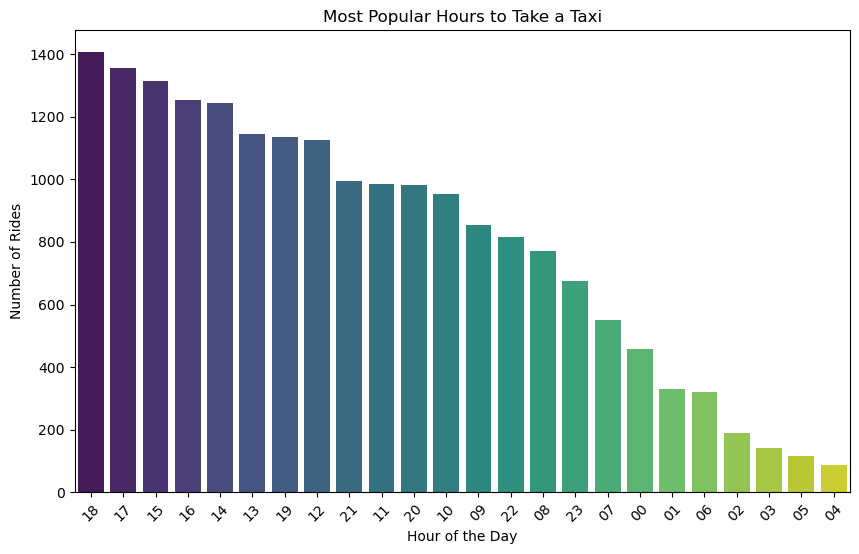

In [114]:
query = """
    SELECT strftime('%H', pickup_time) AS hour, COUNT(*) AS count
    FROM yellowcab
    GROUP BY hour
    ORDER BY count DESC;
"""

# 执行查询并加载数据到 Pandas DataFrame
data = pd.read_sql_query(query, connection)

# 检查数据是否为空
if data.empty:
    print("No data returned from query!")
else:
    # 可视化数据
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data['hour'], y=data['count'], palette="viridis")
    plt.title("Most Popular Hours to Take a Taxi")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Rides")
    plt.xticks(rotation=45)
    plt.show()

/var/folders/sy/rlmr5st115vcf8xjzcq4_hdw0000gn/T/ipykernel_15540/1493970095.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['month'], y=data['avg_distance'], palette="coolwarm")


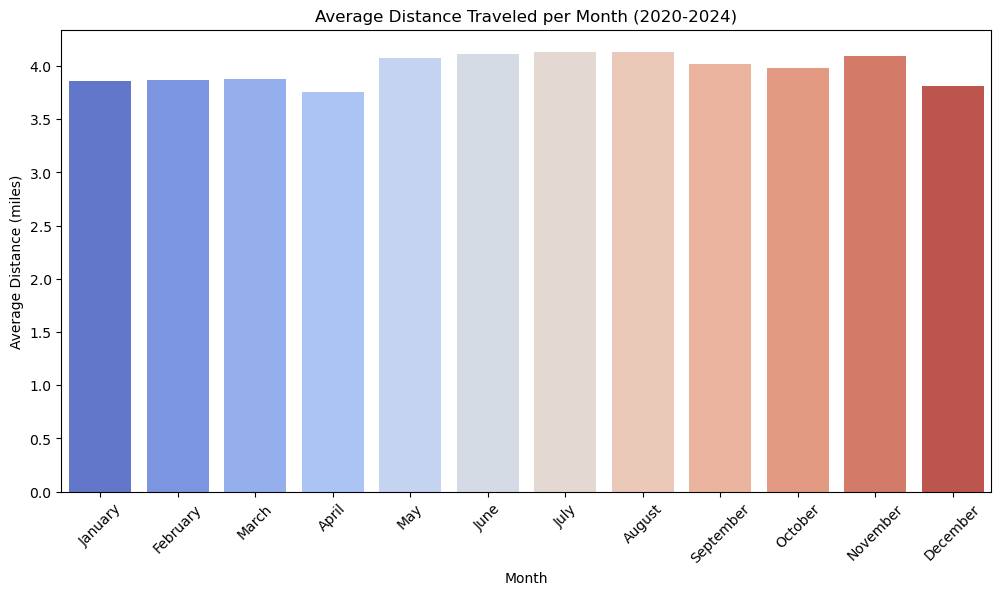

In [116]:
query = """
    SELECT strftime('%m', pickup_time) AS month, AVG(trip_distance) AS avg_distance
    FROM (
        SELECT pickup_time, trip_distance FROM yellowcab
        UNION ALL
        SELECT pickup_time, trip_distance FROM uber
    )
    WHERE pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month;
"""

# 执行查询并加载数据到 Pandas DataFrame
data = pd.read_sql_query(query, connection)

# 格式化月份数据为完整月份名称
data['month'] = pd.to_datetime(data['month'], format='%m').dt.strftime('%B')

# 可视化数据
plt.figure(figsize=(12, 6))
sns.barplot(x=data['month'], y=data['avg_distance'], palette="coolwarm")
plt.title("Average Distance Traveled per Month (2020-2024)")
plt.xlabel("Month")
plt.ylabel("Average Distance (miles)")
plt.xticks(rotation=45)
plt.show()


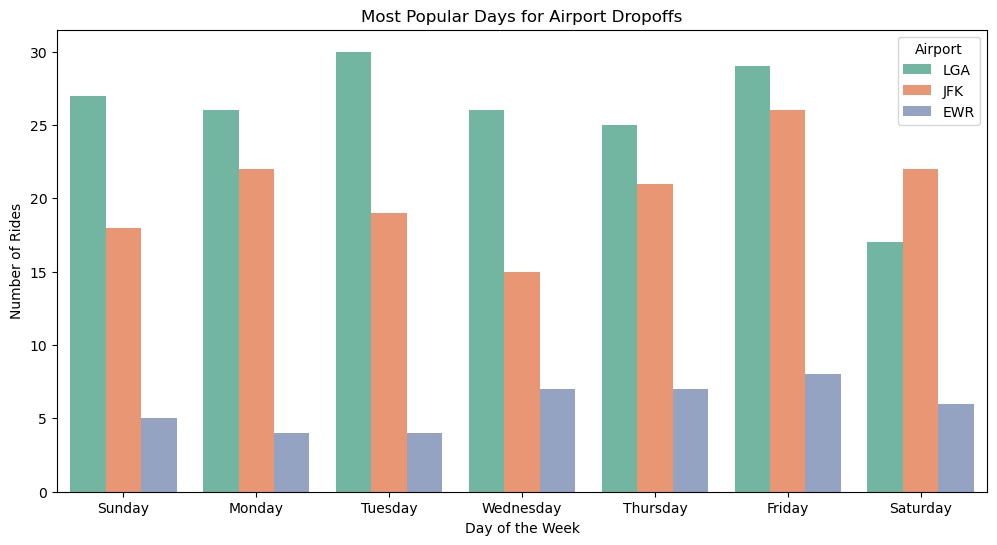

In [118]:
# 定义机场坐标范围
airports = {
    "LGA": {"lat_min": 40.766, "lat_max": 40.776, "lon_min": -73.882, "lon_max": -73.862},
    "JFK": {"lat_min": 40.641, "lat_max": 40.651, "lon_min": -73.789, "lon_max": -73.769},
    "EWR": {"lat_min": 40.689, "lat_max": 40.699, "lon_min": -74.190, "lon_max": -74.170},
}

# 存储每个机场的查询结果
results = []

# 遍历每个机场的边界框，执行查询
for airport, bbox in airports.items():
    query = f"""
        SELECT strftime('%w', pickup_time) AS weekday, COUNT(*) AS count
        FROM yellowcab
        WHERE latitude_dropoff BETWEEN {bbox['lat_min']} AND {bbox['lat_max']}
          AND longitude_dropoff BETWEEN {bbox['lon_min']} AND {bbox['lon_max']}
        GROUP BY weekday
    """
    data = pd.read_sql_query(query, connection)
    data['airport'] = airport
    results.append(data)

# 合并结果到单一的 DataFrame
final_data = pd.concat(results)

# 将星期几数字映射为星期几名称
final_data['weekday'] = final_data['weekday'].astype(int).map({
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
    4: 'Thursday', 5: 'Friday', 6: 'Saturday'
})

# 绘制柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="count", hue="airport", data=final_data, palette="Set2")
plt.title("Most Popular Days for Airport Dropoffs")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Rides")
plt.legend(title="Airport")
plt.show()

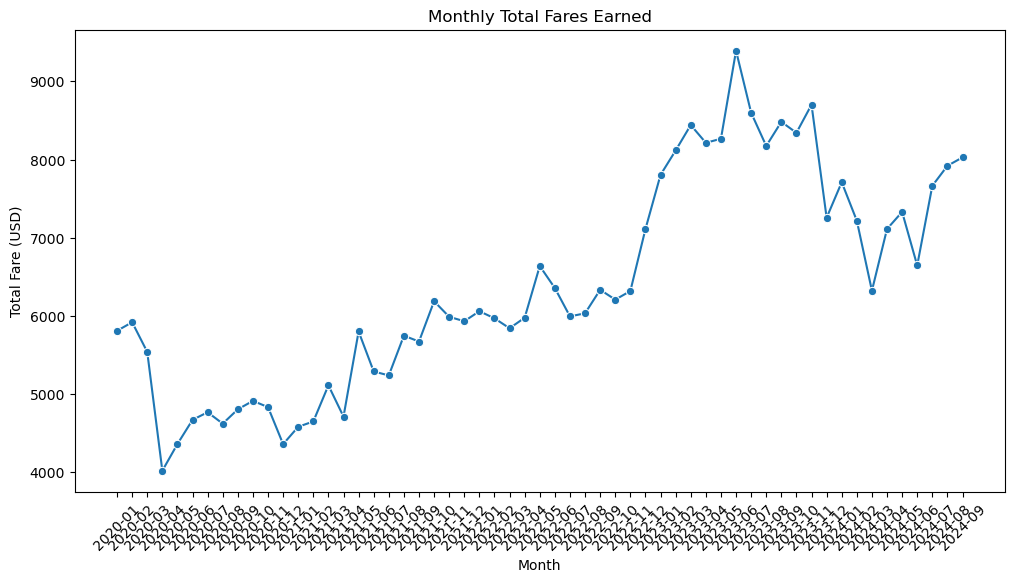

In [124]:
# 定义 SQL 查询
query = """
    SELECT strftime('%Y-%m', pickup_time) AS month, 
           SUM(fare_amount + surcharges + tax + toll) AS total_fare
    FROM yellowcab
    GROUP BY month;
"""

# 执行 SQL 查询并加载数据到 Pandas DataFrame
data = pd.read_sql_query(query, connection)

# 绘制图形
plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="total_fare", data=data, marker="o")
plt.title("Monthly Total Fares Earned")
plt.xlabel("Month")
plt.ylabel("Total Fare (USD)")
plt.xticks(rotation=45)
plt.show()


In [128]:
query = """
    SELECT trip_distance, tip
    FROM yellowcab
    WHERE pickup_time BETWEEN '2022-01-01' AND '2023-12-31';
"""

data = pd.read_sql_query(query, connection)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(x="trip_distance", y="tip_amount", data=data, ax=axs[0, 0])
axs[0, 0].set_title("Tips vs Distance (Yellow Cab)")
axs[0, 0].set_xlabel("Trip Distance (miles)")
axs[0, 0].set_ylabel("Tip Amount (USD)")

sns.scatterplot(x="precipitation", y="tip_amount", data=data, ax=axs[0, 1])
axs[0, 1].set_title("Tips vs Precipitation (Yellow Cab)")
axs[0, 1].set_xlabel("Precipitation (inches)")
axs[0, 1].set_ylabel("Tip Amount (USD)")

plt.tight_layout()
plt.show()

DatabaseError: Execution failed on sql '
    SELECT trip_distance, tip, precipitation
    FROM yellowcab
    WHERE pickup_time BETWEEN '2022-01-01' AND '2023-12-31';
': no such column: precipitation

In [130]:
import geopandas as gpd
import folium
import pandas as pd

query = """
    SELECT latitude_pickup, longitude_pickup
    FROM yellowcab
    WHERE pickup_time BETWEEN '2020-01-01' AND '2020-12-31';
"""
data = pd.read_sql_query(query, connection)

m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

for _, row in data.iterrows():
    folium.CircleMarker(
        location=(row['latitude_pickup'], row['longitude_pickup']),
        radius=1, color="red", fill=True
    ).add_to(m)

m.save("heatmap.html")
print("Heatmap saved as heatmap.html")

Heatmap saved as heatmap.html
